In [1]:
import pandas as pd

path = 'wiktextract_data_cleaned_2.csv'

# read data from csv file
df = pd.read_csv(path)
df.head()

,word,lang_code,ipa
0,orient,en,/ˈɔː.ɹɪ.ənt/
1,orient,en,/ˈɔ.ɹi.ənt/
2,orient,en,/ˈɒ.ɹɪ-/
3,orient,en,/ˈɔː.ɹɪ.ənt/
4,orient,en,/ˈɔ.ɹi.ənt/


In [2]:
# remove duplicates, keep one pronounciation per word and lang_code combination
df.drop_duplicates(subset=['word', 'lang_code'], inplace=True)

# remove languages that are split in the ipa-dict
df.drop(df[df['lang_code'] == 'en'].index, inplace=True)
df.drop(df[df['lang_code'] == 'fr'].index, inplace=True)
df.drop(df[df['lang_code'] == 'vi'].index, inplace=True)
df.drop(df[df['lang_code'] == 'zh'].index, inplace=True)
df.drop(df[df['lang_code'] == 'es'].index, inplace=True)

In [3]:
import glob
path = 'ipa_data_csv' 
all_files = glob.glob(path + "/*.csv")
df2 = pd.DataFrame(columns=['word', 'ipa', 'lang_code'])
for f in all_files:
    lang_code = f.split('\\')[-1].split('.')[0] 
    
    # remove languages that by inspection had weird symbols in their ipa-data    
    if lang_code in ['ar', 'fa', 'ja']:
        continue
        
    csv_data = pd.read_csv(f, names=['word', 'ipa'])
        
    csv_data['lang_code'] = lang_code
    df2 = df2.append(csv_data)

In [4]:
# remove duplicates, keep one pronounciation per word and lang_code combination
df2.drop_duplicates(subset=['word', 'lang_code'], inplace=True)


In [5]:
# in case of multiple pronounciations, keep first one
df2['ipa'] = df2['ipa'].apply(lambda x: x.split(', ')[0])

In [6]:
# append two data frames with information from ipa-dict and wiktionary and drop duplicate information. 
df = df.append(df2).drop_duplicates(subset=['word', 'lang_code'], keep='last')

In [7]:
df.reset_index(inplace=True, drop=True)

In [8]:
lang_code_count = df.groupby(['lang_code']).size().reset_index().rename(columns={0:'count'})
under_represented = lang_code_count[lang_code_count['count'] < 100]['lang_code'].values.tolist()
under_represented_index = df[df['lang_code'].isin(under_represented)].index
df.drop(under_represented_index, inplace=True)

In [9]:
# remove brackets 
df['ipa'] = df['ipa'].apply(lambda x : x[1:-1])

In [10]:
def pad_underscores(x):
    return '_' + x + '_'     

In [11]:
# pad with underscores to denote  start and end of pronunciation
df['ipa'] = df['ipa'].apply(lambda x: pad_underscores(x))

In [12]:
df.drop(df[df['lang_code'].isin(['ar', 'fa', 'ja'])].index, inplace=True)

In [13]:
lang_groups_1 = df[['lang_code', 'ipa']].groupby(['lang_code'])

In [14]:
from iso639 import languages
def map_lang_code(lang_code):
    try:
        if len(lang_code) == 2:
            return languages.get(part1=lang_code).name
        elif len(lang_code) == 3:
            return languages.get(part3=lang_code).name
        elif '_' in lang_code:
            return languages.get(part1=lang_code.split('_')[0]).name + '_' + lang_code.split('_')[1]
        else:
            return None
    except KeyError:
        return None

In [ ]:
# split each word in a language in n-grams for n is 2, 3 and 4 grams
# create a csv file with n-grams per languages
size = []
for i in range(2,5):
    for lang, group in lang_groups_1:
        path = 'all_' + str(i) + '.csv'
        n_grams = []
        for ipa in group['ipa']:
            j = 0
            while j + i < len(ipa):
                n_grams.append(ipa[j:j+i])
                j += 1
        dfn = pd.DataFrame({'lang_code': [lang], 'n_grams':[n_grams]})
        dfn['language'] = dfn['lang_code'].apply(lambda x: map_lang_code(x))

# uncomment to save
#        dfn.to_csv(path, mode='a', header=False)

In [15]:
# per language, combine all the pronunciations to form one big list
lang_groups = df[['lang_code', 'ipa']].groupby(['lang_code'])['ipa'].apply(list).reset_index()

In [16]:
# count amount of words per language
lang_groups['size'] = lang_groups['ipa'].apply(lambda x: len(x))

In [17]:
# map each list with pronuncations to one big string. Necessary to be able to run the TF-IDF vectorizer later.
lang_groups['ipa'] = lang_groups['ipa'].apply(lambda x: ' '.join(x))

In [18]:
# add a column that maps a language code to actual language name
lang_groups['language'] = lang_groups['lang_code'].apply(lambda x: map_lang_code(x))

In [19]:
armenian = ['hy']
albanian = ['sq']


#indian Iranian
indian = ['hi', 'ur', 'bn', 'mr', 'gu', 'as', 'sa', 'pa' ]
iranian = ['kmr', 'ckb']
indo_iranian = [indian, iranian]

# greek
greek = ['el', 'grc']

# italic
italic = ['ca', 'dlm', 'es_ES', 'es_MX', 'fr_FR', 'fr_QC', 'gl', 'it', 'lad', 'pt', 'ro', 'sc', 'scn', 'la', 'lmo', 'lij', 'co']

# celtic
celtic = ['br', 'cy', 'gd', 'ga'] 

# germanic
germanic_n = ['nn', 'nb', 'da', 'fo', 'is', 'sv']
germanic_w = ['en_UK', 'en_US', 'ofs', 'frr', 'fy', 'nl', 'dum', 'de', 'gml', 'goh', 'gsw', 'nds', 'af', 'yi', 'li', 'lb', 'hrx']
germanic_e = ['got']
germanic = [germanic_n, germanic_w, germanic_e]


# balto-slavic
slavic_w = ['pl', 'sk', 'cs']
slavic_s = ['bg', 'mk', 'sl']
slavic_e = ['ru', 'uk', 'be']

baltic = ['lt','lv']

slavic = [slavic_w, slavic_s, slavic_e]

balto_slavic = [baltic, slavic]


proto_indo_european = [balto_slavic, germanic, celtic, italic, greek, albanian, armenian, indo_iranian]

# big four means the four biggest language groups within the indo-european languages
proto_indo_european_big_four = [balto_slavic, germanic, italic, indo_iranian]

def flatten(container):
    flat = []
    for i in container:
        if isinstance(i, list):
            for j in flatten(i):
                flat.append(j)
        else:
            flat.append(i)
    return flat

big_four_list = flatten(proto_indo_european_big_four)
big_four_dict = {'balto_slavic': flatten(balto_slavic), 
                 'germanic': flatten(germanic), 
                 'italic': flatten(italic), 
                 'indo_iranian': flatten(indo_iranian)}
big_four_labels = flatten([[i] * len(group) for i, group in enumerate(big_four_dict.values()) ])

In [20]:
# big four data frame
bfdf = lang_groups[lang_groups['lang_code'].isin(big_four_list)]

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector for 1-grams
vbf1 = TfidfVectorizer(ngram_range=(1,1), analyzer= 'char_wb', sublinear_tf=True)
xbf1 = vbf1.fit_transform(bfdf['ipa'])

In [22]:
# TF-IDF vector for 2-grams
vbf2 = TfidfVectorizer(ngram_range=(2,2), analyzer= 'char_wb', sublinear_tf=True)
xbf2 = vbf2.fit_transform(bfdf['ipa'])


In [23]:
# TF-IDF vector for 3-grams
vbf3 = TfidfVectorizer(ngram_range=(3,3), analyzer= 'char_wb', sublinear_tf=True)
xbf3 = vbf3.fit_transform(bfdf['ipa'])

In [24]:
# TF-IDF vector for 4-grams
vbf4 = TfidfVectorizer(ngram_range=(4,4), analyzer= 'char_wb', sublinear_tf=True)
xbf4 = vbf4.fit_transform(bfdf['ipa'])

In [26]:
# TF-IDF vectors for Indo-European languages including four random other languages

other = lang_groups[(lang_groups['language'] == 'Chinese_hant') | (lang_groups['language'] == 'Chinese_hans') | 
                   (lang_groups['language'] == 'Finnish') | (lang_groups['language'] == 'Korean')]
other_included = bfdf.append(other)['ipa']
other_vec_1 = TfidfVectorizer(ngram_range=(1,1), analyzer= 'char_wb', sublinear_tf=True).fit_transform(other_included)
other_vec_2 = TfidfVectorizer(ngram_range=(2,2), analyzer= 'char_wb', sublinear_tf=True).fit_transform(other_included)
other_vec_3 = TfidfVectorizer(ngram_range=(3,3), analyzer= 'char_wb', sublinear_tf=True).fit_transform(other_included)
other_vec_4 = TfidfVectorizer(ngram_range=(4,4), analyzer= 'char_wb', sublinear_tf=True).fit_transform(other_included)

In [27]:
# get vector dimensions of n-grams
pd.DataFrame(zip(range(1,5), [len(vbf1.get_feature_names()), len(vbf2.get_feature_names()), len(vbf3.get_feature_names()), len(vbf4.get_feature_names())]), columns=['n','dimensions']).set_index('n', drop=True)

,dimensions
n,
1,221
2,7886
3,101801
4,574569


Text(0, 0.5, 'size (logarithmic-scale)')

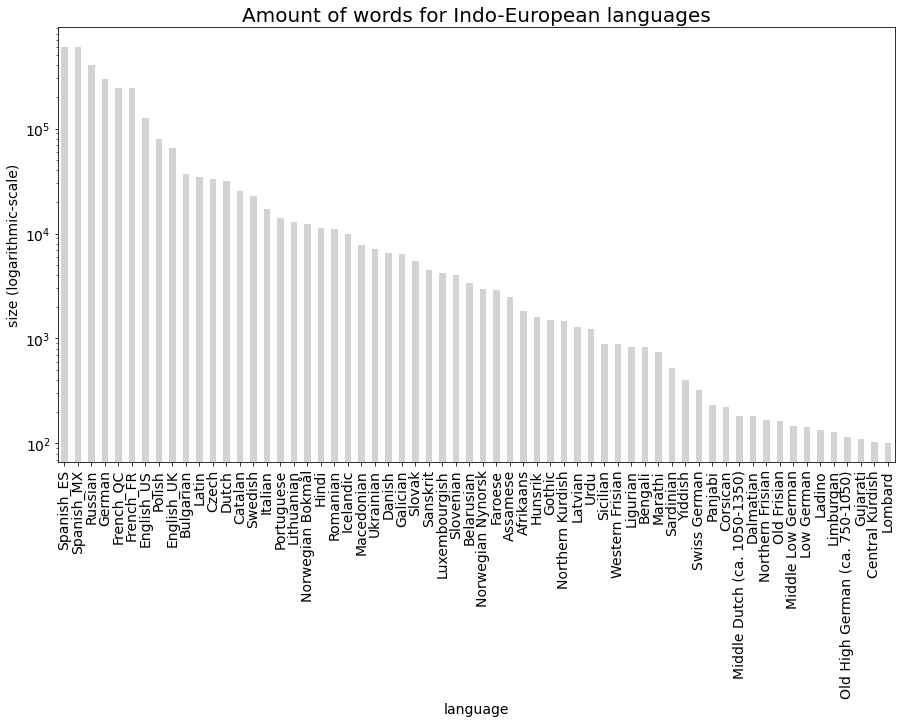

In [28]:
#figure to display the data distribution
ax = bfdf.sort_values(by='size',ascending=False).plot.bar(x='language',  y='size', legend=False, rot=90, figsize=(15,8), title='Amount of words for Indo-European languages', fontsize=14, color='lightgrey')
ax.title.set_size(20)
ax.set_yscale('log')
ax.set_xlabel('language', fontsize=14)
ax.set_ylabel('size (logarithmic-scale)', fontsize=14)

In [ ]:
# run k-means 100 times for all types of n-grams and find Adjusted Rand Index and Silhouette score each iteration

data= [reduced_bf1, reduced_bf2, reduced_bf3, reduced_bf4]
data_ri = []
data_si_km = []
data_si_og = []
data_max_kmeans = []
data_min_kmeans = []

for x in data:
    
    ri = []
    
    si_km = []
    si_og = []
    
    max_ri = -1
    min_ri = 1
    
    kmeans_data = []
    
    for i in range(1000):
        
        kmeans = KMeans(n_clusters=4).fit_predict(x)
        kmeans_df = pd.DataFrame(zip(bfdf['lang_code'], kmeans), columns=['lang_code','label'])
        compare_label = kmeans_df.merge(big_four_label_df, on='lang_code')
        rand_score = adjusted_rand_score(compare_label['label_x'], compare_label['label_y'] )
        sil_score_km = silhouette_score(reduced, kmeans)
        sil_score_og = silhouette_score(reduced, big_four_labels)
        
        kmeans_data.append(kmeans)
        ri.append(rand_score)
        
        si_km.append(sil_score_km)
        si_og.append(sil_score_og)
        
    data_max_kmeans.append(kmeans_data[ri.index(np.max(ri))])
    data_min_kmeans.append(kmeans_data[ri.index(np.min(ri))])
    
    data_ri.append(ri)
    
    data_si_km.append(si_km)  
    data_si_og.append(si_og)
    

In [552]:
# find statistics for ARI values obtained from the 100 iterations of k-means
rand_score_data = []
for i in range(4):
    rand_score_data.append((round(np.min(data_ri[i]),4), round(np.max(data_ri[i]),4), round(np.mean(data_ri[i]),4)))
pd.DataFrame(rand_score_data, columns=['min','max','mean'])


,min,max,mean
0,0.1203,0.7426,0.4181
1,0.0614,0.8089,0.4330
2,-0.0139,0.6933,0.2670
3,-0.0355,0.6396,0.1190


In [548]:
# find statistics for silhoette score values obtained from the 100 iterations of k-means
si_score_data = []
for i in range(4):
    si_score_data.append((round(np.min(data_si_km[i]), 4), round(np.max(data_si_km[i]), 4), round(np.mean(data_si_km[i]),4)))
pd.DataFrame(si_score_data, columns=['min','max','mean'])


,min,max,mean
0,0.0440,0.0968,0.0837
1,-0.0163,0.0901,0.0612
2,-0.0782,0.0898,0.0299
3,-0.1206,0.0965,0.0041


In [621]:
# label_x is for linguistic classification and label_y for the cluster labels. This dataframe shows how many languages 
# from a linguistic group (label_x) are classified with a specific label by k-means (label_y)
# This is used to assign the colors in the following plot.
kmeans_df = pd.DataFrame(zip(bfdf['lang_code'], data_max_kmeans[1]), columns=['lang_code','label'])
compare_label_max = kmeans_df.merge(big_four_label_df, on='lang_code')
compare_label_max.groupby(['label_x', 'label_y']).count()

lang_code
label_x label_y           
0       3                8
1       1                1
        2               15
2       1               23
        3                1
3       0               11
        2                2
        3                1

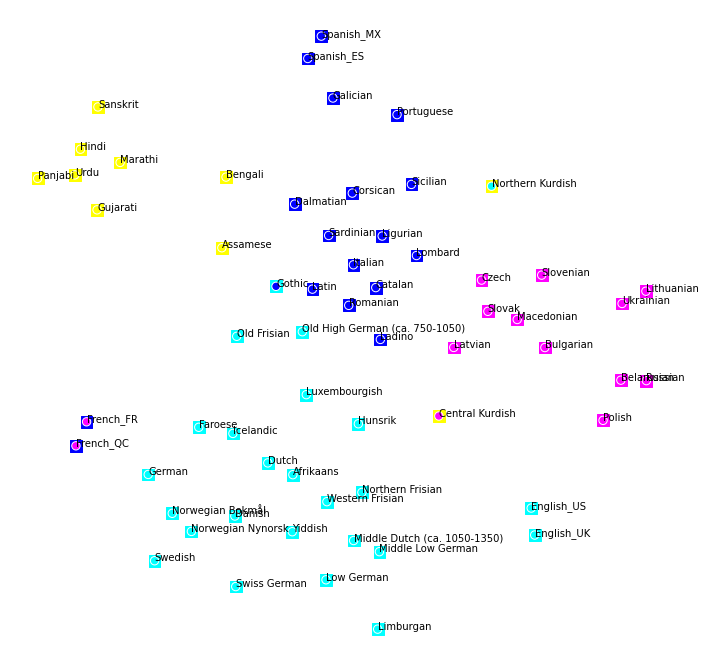

In [619]:
# Plot showing the overlap of linguistic classification and k-means using the k-means classification that had the 
# highest rand score in the 100 iterations 
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf2[:, 0], plot_reduced_bf2[:, 1], marker="s", s=140, c=compare_label_max['label_y'].map(colors_1))
colors_2 = {0:'yellow', 1:'blue', 2:'cyan', 3:'magenta'}
ax.scatter(plot_reduced_bf2[:, 0], plot_reduced_bf2[:, 1], marker="o", s=70, c=compare_label_max['label_x'].map(colors_2), linewidths=1,
              edgecolors='white')
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf2[i, 0], plot_reduced_bf2[i, 1]), size=10)

In [328]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Do dimension reduction for each TD-IDF matrix using SVD for cluster vectors
reduced_bf1 = TruncatedSVD(n_components=50, random_state=0).fit_transform(xbf1)
reduced_bf2 = TruncatedSVD(n_components=50, random_state=0).fit_transform(xbf2)
reduced_bf3 = TruncatedSVD(n_components=50, random_state=4).fit_transform(xbf3)
reduced_bf4 = TruncatedSVD(n_components=50, random_state=4).fit_transform(xbf4)


# Do dimension reduction for each SVD matrix using t-SNE for visualisation 
plot_reduced_bf1 = TSNE(random_state=8, perplexity=10).fit_transform(reduced_bf1)
plot_reduced_bf2 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_bf2)
plot_reduced_bf3 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_bf3)
plot_reduced_bf4 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_bf4)




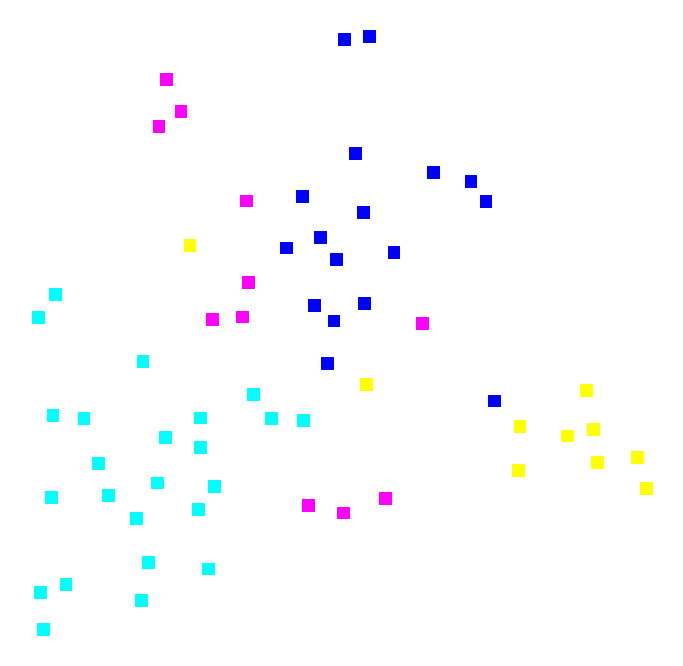

In [608]:
# Dataframe for languages from the big four families with a label where the same number indicates same family
big_four_label_df = pd.DataFrame(zip(big_four_list, big_four_labels), columns=['lang_code','label'])

# Merge k-means labels and linguistic labels to be able to compare the partitions
bfdf_label = bfdf[['lang_code']].merge(big_four_label_df, on='lang_code')

fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=()) 
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf1[:, 0], plot_reduced_bf1[:, 1], marker="s", s=140, c=bfdf_label['label'].map(colors_1))

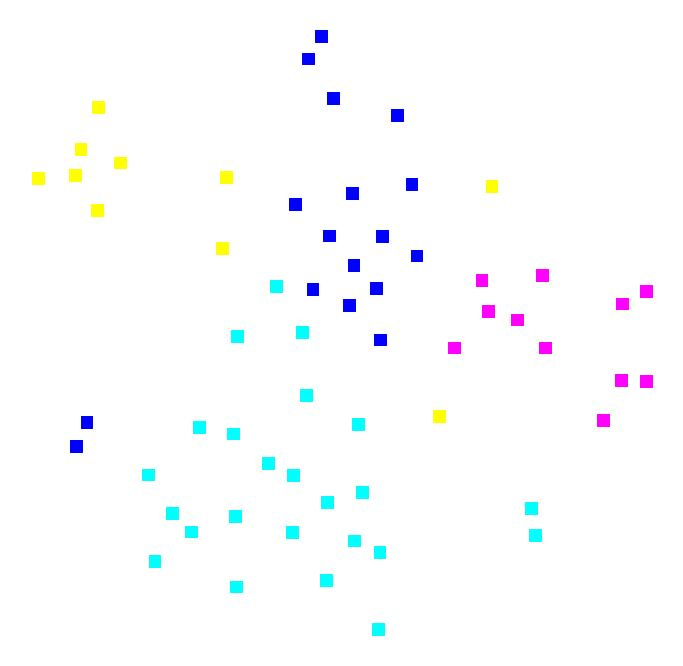

In [609]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf2[:, 0], plot_reduced_bf2[:, 1],marker="s", s=140, c=bfdf_label['label'].map(colors_1))

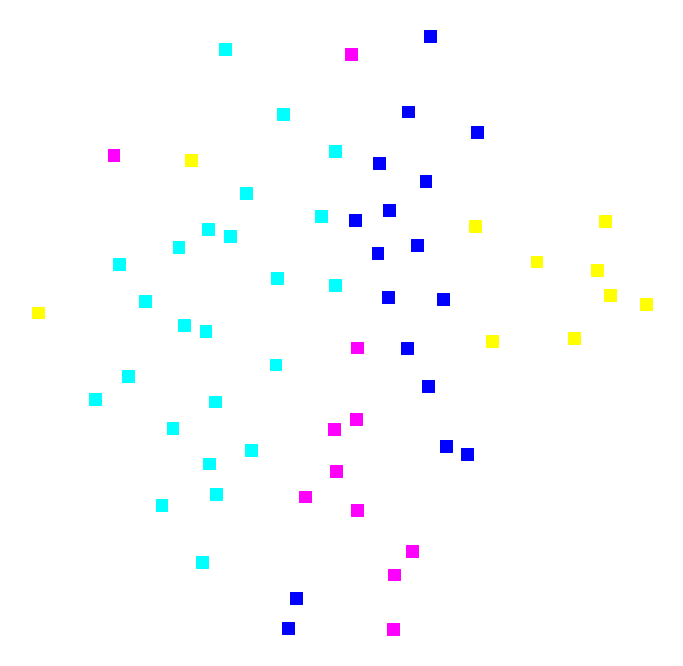

In [610]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf3[:, 0], plot_reduced_bf3[:, 1],marker="s", s=140, c=bfdf_label['label'].map(colors_1))

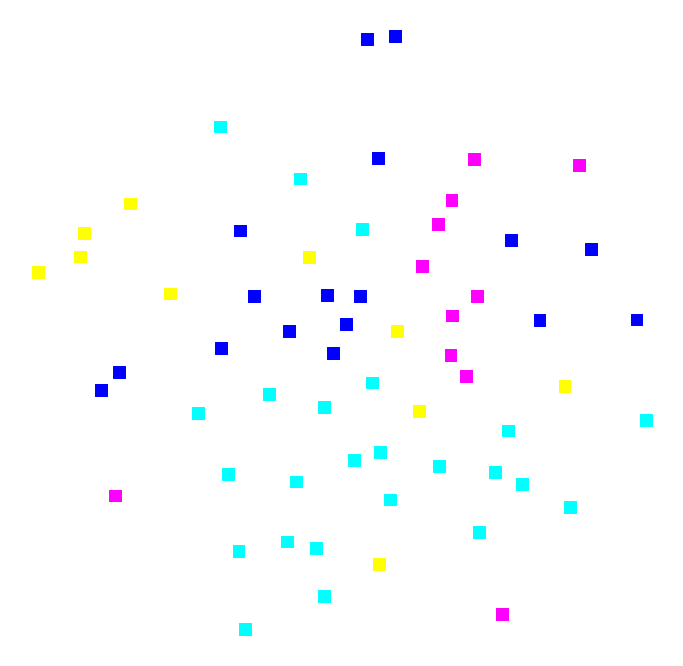

In [611]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf4[:, 0], plot_reduced_bf4[:, 1],marker="s", s=140, c=bfdf_label['label'].map(colors_1))

<ipython-input-32-1e12b93d7af0>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, distortions[i], 'bx-', color=colors[i], label=str(i+1) + '-grams')


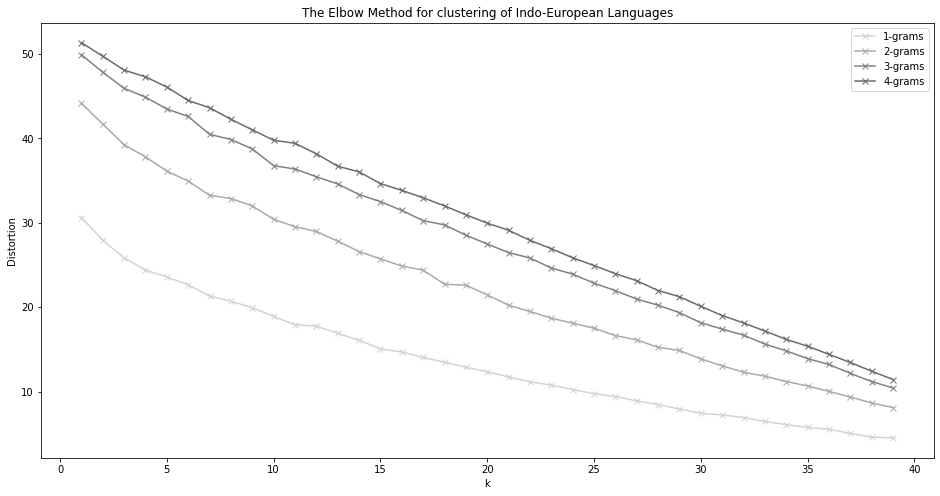

In [32]:
# Elbow method to find optimal k
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = [reduced_bf1, reduced_bf2, reduced_bf3, reduced_bf4]
distortions = [[],[],[],[]]
K = range(1,40)
for k in K:
    for i in range(4):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data[i])
        distortions[i].append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
colors=[ 'lightgray','darkgray','gray', 'dimgray']
for i in range(4):
    plt.plot(K, distortions[i], 'bx-', color=colors[i], label=str(i+1) + '-grams')
plt.legend()
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for clustering of Indo-European Languages')
plt.show()   
    


In [636]:
# k-means clustering for all variation of n in n-grams
kmeans_1 = KMeans(n_clusters=4).fit_predict(reduced_bf1)
kmeans_2 = KMeans(n_clusters=4).fit_predict(reduced_bf2)
kmeans_3 = KMeans(n_clusters=4).fit_predict(reduced_bf3)
kmeans_4 = KMeans(n_clusters=4).fit_predict(reduced_bf4)

In [637]:
# Dataframe for languages from the big four families with a label where the same number indicates same family
big_four_label_df = pd.DataFrame(zip(big_four_list, big_four_labels), columns=['lang_code','label'])

# Merge k-means labels and linguistic labels to be able to compare the partitions
k_means_df1 = pd.DataFrame(zip(bfdf['lang_code'], kmeans_1), columns=['lang_code','label'])
compare_label1 = k_means_df1.merge(big_four_label_df, on='lang_code')
k_means_df2 = pd.DataFrame(zip(bfdf['lang_code'], kmeans_2), columns=['lang_code','label'])
compare_label2 = k_means_df2.merge(big_four_label_df, on='lang_code')
k_means_df3 = pd.DataFrame(zip(bfdf['lang_code'], kmeans_3), columns=['lang_code','label'])
compare_label3 = k_means_df3.merge(big_four_label_df, on='lang_code')
k_means_df4 = pd.DataFrame(zip(bfdf['lang_code'], kmeans_4), columns=['lang_code','label'])
compare_label4 = k_means_df4.merge(big_four_label_df, on='lang_code')

In [505]:
# Do dimension reduction for each TD-IDF matrix including the four random languages using SVD for cluster vectors
reduced_other_1 = TruncatedSVD(n_components=50, random_state=0).fit_transform(other_vec_1)
reduced_other_2 = TruncatedSVD(n_components=50, random_state=0).fit_transform(other_vec_2)
reduced_other_3 = TruncatedSVD(n_components=50, random_state=0).fit_transform(other_vec_3)
reduced_other_4 = TruncatedSVD(n_components=50, random_state=0).fit_transform(other_vec_4)

# Do dimension reduction for each SVD matrix ncluding the four random languages  using t-SNE for visualisation 
plot_reduced_other_1 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_other_1)
plot_reduced_other_2 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_other_2)
plot_reduced_other_3 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_other_3)
plot_reduced_other_4 = TSNE(random_state=0, perplexity=10).fit_transform(reduced_other_4)

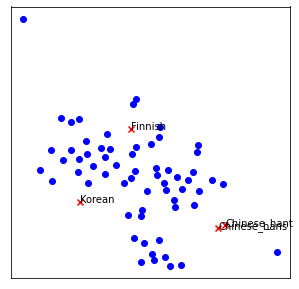

In [500]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=(), yticks=())
ax.scatter(plot_reduced_other_1[-4:, 0], plot_reduced_other_1[-4:, 1], marker="x", c='red')
ax.scatter(plot_reduced_other_1[:-4, 0], plot_reduced_other_1[:-4, 1], marker="o", c='blue')
for i, language in enumerate(other['language'].tolist()):
    ax.annotate(language, (plot_reduced_other_1[(-4+i), 0], plot_reduced_other_1[(-4+i), 1]), size=10)

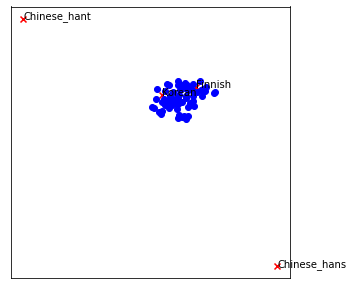

In [501]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=(), yticks=())
ax.scatter(plot_reduced_other_2[-4:, 0], plot_reduced_other_2[-4:, 1], marker="x", c='red')
ax.scatter(plot_reduced_other_2[:-4, 0], plot_reduced_other_2[:-4, 1], marker="o", c='blue')
for i, language in enumerate(other['language'].tolist()):
    ax.annotate(language, (plot_reduced_other_2[(-4+i), 0], plot_reduced_other_2[(-4+i), 1]), size=10)

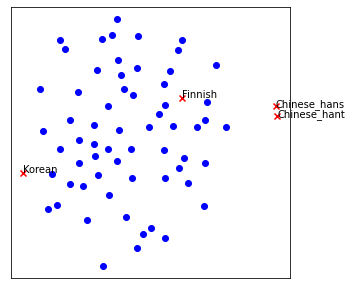

In [502]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=(), yticks=())
ax.scatter(plot_reduced_other_3[-4:, 0], plot_reduced_other_3[-4:, 1], marker="x", c='red')
ax.scatter(plot_reduced_other_3[:-4, 0], plot_reduced_other_3[:-4, 1], marker="o", c='blue')
for i, language in enumerate(other['language'].tolist()):
    ax.annotate(language, (plot_reduced_other_3[(-4+i), 0], plot_reduced_other_3[(-4+i), 1]), size=10)

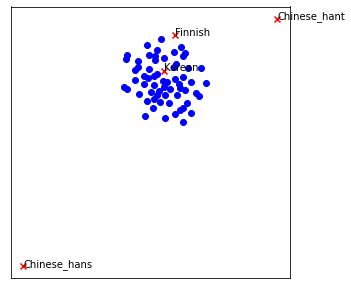

In [503]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=(), yticks=())
ax.scatter(plot_reduced_other_4[-4:, 0], plot_reduced_other_4[-4:, 1], marker="x", c='red')
ax.scatter(plot_reduced_other_4[:-4, 0], plot_reduced_other_4[:-4, 1], marker="o", c='blue')
for i, language in enumerate(other['language'].tolist()):
    ax.annotate(language, (plot_reduced_other_4[(-4+i), 0], plot_reduced_other_4[(-4+i), 1]), size=10)

In [301]:
compare_label1.groupby(['label_x', 'label_y']).count()

languages
label_x label_y           
0       3                8
1       0               11
        1                2
        2                9
        3                2
2       1               19
        2                2
3       1                3
        2                6

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf1[:, 0], plot_reduced_bf1[:, 1], marker="s", s=140, c=compare_label1['label_y'].map(colors_1))
colors_2 = {0:'yellow', 1:'blue', 2:'magenta', 3:'cyan'}
ax.scatter(plot_reduced_bf1[:, 0], plot_reduced_bf1[:, 1], marker="o", s=70, c=compare_label1['label_x'].map(colors_2), linewidths=1,
              edgecolors='white')
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf1[i, 0], plot_reduced_bf1[i, 1]), size=10)

In [625]:
compare_label2.groupby(['label_x', 'label_y']).count()

lang_code
label_x label_y           
0       1               12
        2                2
        3                1
1       3                6
2       0               11
        1                4
        2               15
        3                3
3       1                8

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf2[:, 0], plot_reduced_bf2[:, 1], marker="s", s=140, c=compare_label2['label_y'].map(colors_1))
colors_2 = {0:'magenta', 1:'magenta', 2:'yellow', 3:'cyan'}
ax.scatter(plot_reduced_bf2[:, 0], plot_reduced_bf2[:, 1], marker="o", s=70, c=compare_label2['label_x'].map(colors_2), linewidths=1,
              edgecolors='white')
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf2[i, 0], plot_reduced_bf2[i, 1]), size=11)

In [318]:
compare_label3.groupby(['label_x', 'label_y']).count()

languages
label_x label_y           
0       0                3
        1               24
        2                2
        3                1
1       3                8
2       2                3
3       0                8
        2               12
        3                1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf3[:, 0], plot_reduced_bf3[:, 1], marker="s", s=140, c=compare_label3['label_y'].map(colors_1))
colors_2 = {0:'cyan', 1:'yellow', 2:'magenta', 3:'blue'}
ax.scatter(plot_reduced_bf3[:, 0], plot_reduced_bf3[:, 1], marker="o", s=70, c=compare_label3['label_x'].map(colors_2), linewidths=1,
              edgecolors='white')
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf3[i, 0], plot_reduced_bf3[i, 1]), size=10)

In [320]:
compare_label4.groupby(['label_x', 'label_y']).count()

languages
label_x label_y           
0       2                1
1       2                2
2       0               11
        1               24
        2               11
        3               10
3       2                3

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf4[:, 0], plot_reduced_bf4[:, 1], marker="s", s=140, c=compare_label4['label_y'].map(colors_1))
colors_2 = {0:'magenta', 1:'cyan', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf4[:, 0], plot_reduced_bf4[:, 1], marker="o", s=70, c=compare_label4['label_x'].map(colors_2), linewidths=1,
              edgecolors='white')
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf4[i, 0], plot_reduced_bf4[i, 1]), size=10)

In [137]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import rand_score

In [568]:
adjusted_rand_score(compare_label1['label_x'], compare_label1['label_y'] )

0.424428329200831

In [574]:
adjusted_rand_score(compare_label2['label_x'], compare_label2['label_y'] )

0.30485518789591376

In [566]:
adjusted_rand_score(compare_label3['label_x'], compare_label3['label_y'] )

0.14349001825204366

In [567]:
adjusted_rand_score(compare_label4['label_x'], compare_label4['label_y'] )

0.08962200787412224

In [337]:
adjusted_rand_score(compare_label123['label_x'], compare_label123['label_y'] )

0.424428329200831

In [346]:
from sklearn.metrics import silhouette_score
silhouette_score(reduced_bf1, kmeans_1)

0.08325449296881088

In [ ]:
silhouette_score(reduced_bf2, kmeans_2)

In [ ]:
silhouette_score(reduced_bf3, kmeans_3)

In [ ]:
silhouette_score(reduced_bf4, kmeans_4)

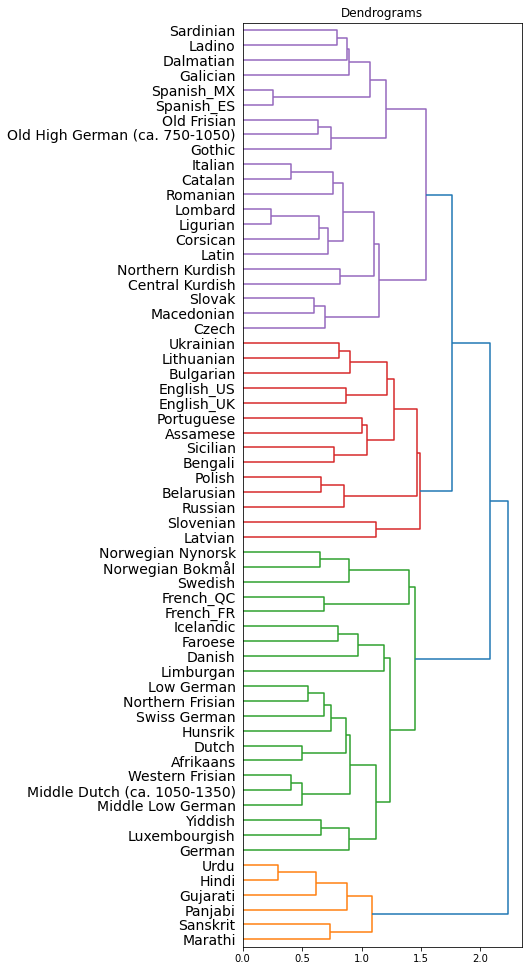

In [627]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(5, 17))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(reduced_bf1, method='ward'), labels=bfdf['language'].tolist(), orientation='right',  leaf_font_size=14)

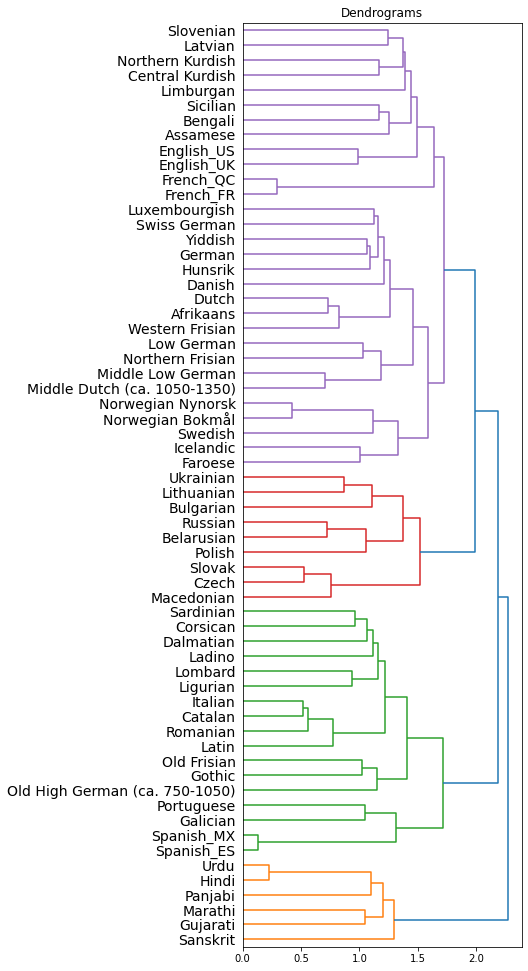

In [583]:
import scipy.cluster.hierarchy as shc
sch.set_link_color_palette(['c', 'm', 'y', 'k'])
plt.figure(figsize=(5, 17))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(reduced_bf2, method='ward'), color_threshold=1.8 , labels=bfdf['language'].tolist(), orientation='right',  leaf_font_size=14)

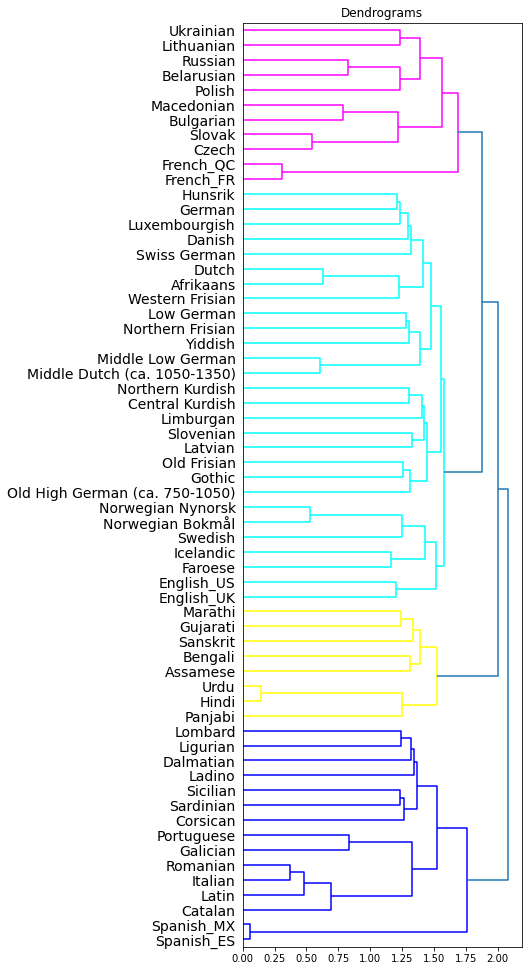

In [645]:
import scipy.cluster.hierarchy as shc
shc.set_link_color_palette(['blue', 'yellow', 'cyan', 'magenta'])
plt.figure(figsize=(5, 17))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(reduced_bf3, method='ward'), labels=bfdf['language'].tolist(), color_threshold=1.8,  orientation='right',  leaf_font_size=14)

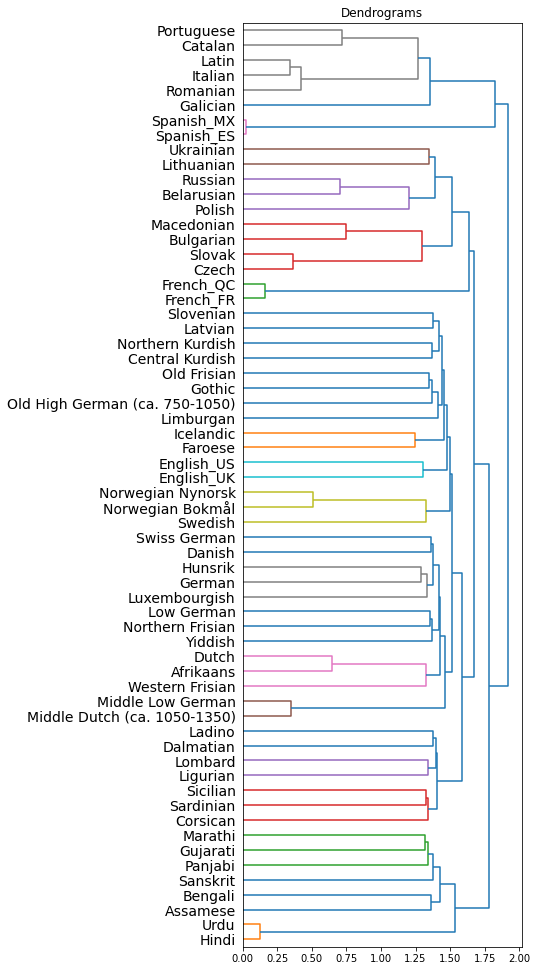

In [582]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(5, 17))  
plt.title("Dendrograms") 
#color_threshold=1.6,
dend = shc.dendrogram(shc.linkage(reduced_bf4, method='ward'), labels=bfdf['language'].tolist(),   orientation='right',  leaf_font_size=14)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster1 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster1.fit_predict(reduced_bf1)

In [ ]:
cluster2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster2.fit_predict(reduced_bf2)

In [ ]:
cluster3 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster3.fit_predict(reduced_bf3)

In [ ]:
cluster4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster4.fit_predict(reduced_bf4)

In [187]:
hac_df1 = pd.DataFrame(zip(bfdf['lang_code'], cluster1.labels_), columns=['languages','label'])
hac_compare_label1 = hac_df1.merge(big_four_label_df, on='languages')
rand_score(hac_compare_label1['label_x'], hac_compare_label1['label_y'] )

0.7715494447382337

In [177]:
hac_df2 = pd.DataFrame(zip(bfdf['lang_code'], cluster.labels_), columns=['languages','label'])
hac_compare_label2 = hac_df2.merge(big_four_label_df, on='languages')
rand_score(hac_compare_label2['label_x'], hac_compare_label2['label_y'] )

0.4547858276044421

In [178]:
hac_df3 = pd.DataFrame(zip(bfdf['lang_code'], cluster3.labels_), columns=['languages','label'])
hac_compare_label3 = hac_df3.merge(big_four_label_df, on='languages')
rand_score(hac_compare_label3['label_x'], hac_compare_label3['label_y'] )

0.9037546271813856

In [179]:
hac_df4 = pd.DataFrame(zip(bfdf['lang_code'], cluster4.labels_), columns=['languages','label'])
hac_compare_label4 = hac_df4.merge(big_four_label_df, on='languages')
rand_score(hac_compare_label4['label_x'], hac_compare_label4['label_y'] )

0.4547858276044421

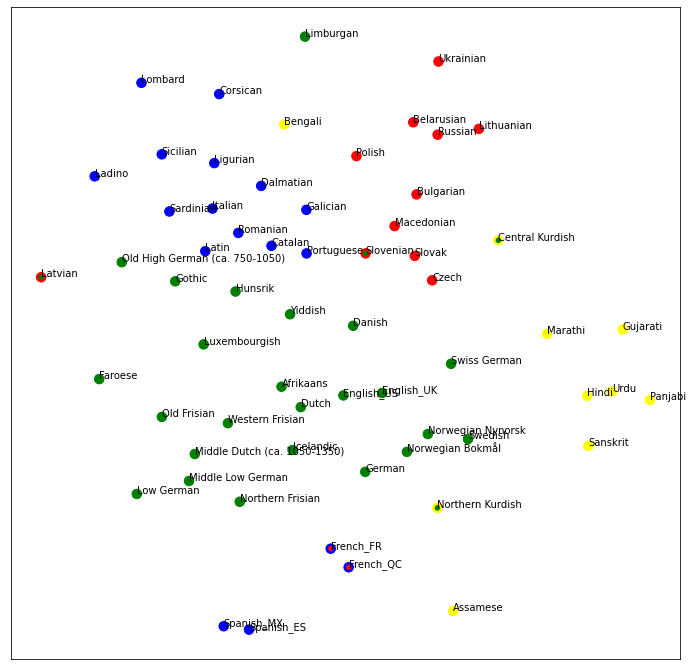

In [43]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 12))
plt.setp(ax, xticks=(), yticks=())
colors_1 = {0:'red', 1:'green', 2:'blue', 3:'yellow'}
ax.scatter(plot_reduced_bf3[:, 0], plot_reduced_bf3[:, 1], marker="o", s=90, c=hac_compare_label2['label_y'].map(colors_1))
colors_2 = {0:'blue', 1:'red', 2:'yellow', 3:'green'}
ax.scatter(plot_reduced_bf3[:, 0], plot_reduced_bf3[:, 1], marker="o", s=20, c=hac_compare_label2['label_x'].map(colors_2))
for i, language in enumerate(bfdf['language'].tolist()):
    ax.annotate(language, (plot_reduced_bf3[i, 0], plot_reduced_bf3[i, 1]), size=10)